In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import feather
import datetime
import itertools
from sklearn import preprocessing
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from catboost import Pool
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error
pd.set_option('display.max_Columns', 100)

In [2]:
train_ = pd.read_feather('../inputs/train_cat_feature.f')
print(train_.shape)
test_ = pd.read_feather('../inputs/test_cat_feature.f')
print(test_.shape)

(8359, 1438)
(8360, 1433)


In [3]:
n_fold = 5

In [4]:
train_.loc[train_['Developer'].isnull(), 'Developer'] = 'None'
train_.loc[train_['Rating'].isnull(), 'Rating'] = 'None'
train_.loc[train_['Genre'].isnull(), 'Genre'] = 'None'
test_.loc[test_['Developer'].isnull(), 'Developer'] = 'None'
test_.loc[test_['Rating'].isnull(), 'Rating'] = 'None'
test_.loc[test_['Genre'].isnull(), 'Genre'] = 'None'

In [5]:
train_.head()

,Name,Platform,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating,User_Score_tbd,User_Score_int,Critic_Score_int,User_Count_log,Year,CE_Platform,CE_Genre,CE_Publisher,CE_Developer,CE_Rating,CE_User_Score_int,CE_Critic_Score_int,TGE_Global_Sales_mean_by_Platform,TGE_Global_Sales_mean_by_Genre,TGE_Global_Sales_mean_by_Rating,TGE_Global_Sales_mean_by_User_Score_int,TGE_Global_Sales_mean_by_Critic_Score_int,TGE_Global_Sales_mean_by_Platform_Genre,TGE_Global_Sales_mean_by_Platform_Rating,TGE_Global_Sales_mean_by_Genre_Rating,TGE_Global_Sales_mean_by_User_Score_int_Platform,TGE_Global_Sales_mean_by_User_Score_int_Genre,TGE_Global_Sales_mean_by_User_Score_int_Rating,TGE_Global_Sales_mean_by_Critic_Score_int_Platform,TGE_Global_Sales_mean_by_Critic_Score_int_Genre,TGE_Global_Sales_mean_by_Critic_Score_int_Rating,TGE_Global_Sales_mean_by_Critic_Score_int_User_Score_int,TGE_Global_Sales_std_by_Platform,TGE_Global_Sales_std_by_Genre,TGE_Global_Sales_std_by_Rating,TGE_Global_Sales_std_by_User_Score_int,TGE_Global_Sales_std_by_Critic_Score_int,TGE_Global_Sales_std_by_Platform_Genre,TGE_Global_Sales_std_by_Platform_Rating,TGE_Global_Sales_std_by_Genre_Rating,...,WD_connect,WD_toshi,WD_alter,WD_eyes,WD_hamster,WD_shock,WD_desu,WD_kami,WD_youkai,WD_saki,WD_drum,WD_loaded,WD_snowboard,WD_roller,WD_main,WD_roku,WD_bout,WD_bound,WD_kill,WD_shiro,WD_shima,WD_kono,WD_runs,WD_mashita,WD_sign,WD_kata,WD_doko,WD_shell,WD_will,WD_limit,WD_cruis,WD_rebel,WD_builder,WD_ippo,WD_split,WD_iris,WD_start,WD_issho,WD_john,WD_michi,LDA_Publisher_0,LDA_Publisher_1,LDA_Publisher_2,LDA_Publisher_3,LDA_Publisher_4,LDA_Publisher_5,LDA_Publisher_6,LDA_Publisher_7,LDA_Publisher_8,LDA_Publisher_9
0,LEGO Batman: The Videogame,Wii,Action,Warner Bros. Interactive Entertainment,180,97,0,28,306,74.0,17.0,7.9,22.0,Traveller's Tales,E10+,0,8.0,7.0,3.135494,2010.0,1320,3370,235,77,1420,2830,2019,93.604962,61.883755,49.257785,106.536082,49.231678,59.678899,52.633663,56.848214,289.223684,112.428571,64.319444,81.140351,48.326531,50.646154,56.630137,444.419232,148.275892,72.187084,341.484617,73.847985,96.258706,76.873366,69.018125,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.744587,0.000142,0.136525,0.000142,0.000142,0.000142,0.000142,0.000142,0.000142,0.117897
1,LEGO Indiana Jones: The Original Adventures,Wii,Action,LucasArts,151,61,0,21,234,78.0,22.0,6.6,28.0,Traveller's Tales,E10+,0,7.0,8.0,3.367296,2008.0,1320,3370,90,77,1420,1634,2366,96.597250,58.394680,49.148789,66.403374,101.466970,54.090000,48.867470,52.439815,213.160000,54.335079,58.293233,483.589744,89.802260,75.231343,96.758065,462.863031,120.188797,75.206074,174.818593,341.906251,91.001509,72.338596,62.128944,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.123729,0.347983,0.223893,0.000369,0.036927,0.000369,0.043541,0.016667,0.206152,0.000369
2,LEGO Batman: The Videogame,PSP,Action,Warner Bros. Interactive Entertainment,56,44,0,27,128,73.0,5.0,7.4,10.0,Traveller's Tales,E10+,0,7.0,7.0,2.397895,2010.0,1209,3370,235,77,1420,1634,2019,29.606403,59.681720,53.568595,64.981846,46.931655,48.185714,53.033898,58.454936,31.886792,58.615789,60.314286,45.701493,47.107692,53.884615,57.709821,69.859005,132.194405,81.714638,150.222097,77.663440,114.136366,82.460642,74.957223,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.744587,0.000142,0.136525,0.000142,0.000142,0.000142,0.000142,0.000142,0.000142,0.117897
3,Combat,2600,Action,Atari,117,7,0,1,125,NaN,NaN,NaN,NaN,None,None,0,NaN,NaN,NaN,1982.0,133,3370,367,6623,6769,9129,8582,65.943662,62.435252,NaN,NaN,NaN,52.269231,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,54.197493,149.649097,NaN,NaN,NaN,49.684249,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000091,0.447350,0.137856,0.000091,0.307130,0.000091,0.000091,0.014219,0.092992,0.000091
4,LEGO Harry

In [6]:
test_.head()

,Name,Platform,Genre,Publisher,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating,User_Score_tbd,User_Score_int,Critic_Score_int,User_Count_log,Year,CE_Platform,CE_Genre,CE_Publisher,CE_Developer,CE_Rating,CE_User_Score_int,CE_Critic_Score_int,TGE_Global_Sales_mean_by_Platform,TGE_Global_Sales_mean_by_Genre,TGE_Global_Sales_mean_by_Rating,TGE_Global_Sales_mean_by_User_Score_int,TGE_Global_Sales_mean_by_Critic_Score_int,TGE_Global_Sales_mean_by_Platform_Genre,TGE_Global_Sales_mean_by_Platform_Rating,TGE_Global_Sales_mean_by_Genre_Rating,TGE_Global_Sales_mean_by_User_Score_int_Platform,TGE_Global_Sales_mean_by_User_Score_int_Genre,TGE_Global_Sales_mean_by_User_Score_int_Rating,TGE_Global_Sales_mean_by_Critic_Score_int_Platform,TGE_Global_Sales_mean_by_Critic_Score_int_Genre,TGE_Global_Sales_mean_by_Critic_Score_int_Rating,TGE_Global_Sales_mean_by_Critic_Score_int_User_Score_int,TGE_Global_Sales_std_by_Platform,TGE_Global_Sales_std_by_Genre,TGE_Global_Sales_std_by_Rating,TGE_Global_Sales_std_by_User_Score_int,TGE_Global_Sales_std_by_Critic_Score_int,TGE_Global_Sales_std_by_Platform_Genre,TGE_Global_Sales_std_by_Platform_Rating,TGE_Global_Sales_std_by_Genre_Rating,TGE_Global_Sales_std_by_User_Score_int_Platform,TGE_Global_Sales_std_by_User_Score_int_Genre,TGE_Global_Sales_std_by_User_Score_int_Rating,TGE_Global_Sales_std_by_Critic_Score_int_Platform,TGE_Global_Sales_std_by_Critic_Score_int_Genre,...,WD_connect,WD_toshi,WD_alter,WD_eyes,WD_hamster,WD_shock,WD_desu,WD_kami,WD_youkai,WD_saki,WD_drum,WD_loaded,WD_snowboard,WD_roller,WD_main,WD_roku,WD_bout,WD_bound,WD_kill,WD_shiro,WD_shima,WD_kono,WD_runs,WD_mashita,WD_sign,WD_kata,WD_doko,WD_shell,WD_will,WD_limit,WD_cruis,WD_rebel,WD_builder,WD_ippo,WD_split,WD_iris,WD_start,WD_issho,WD_john,WD_michi,LDA_Publisher_0,LDA_Publisher_1,LDA_Publisher_2,LDA_Publisher_3,LDA_Publisher_4,LDA_Publisher_5,LDA_Publisher_6,LDA_Publisher_7,LDA_Publisher_8,LDA_Publisher_9
0,Hitman 2: Silent Assassin,XB,Action,Eidos Interactive,84.0,23.0,8.0,19.0,Io Interactive,M,0,8.0,8.0,2.995732,2004.0,824,3370,198,20,1563,2830,2366,28.428571,61.011474,96.410622,100.864791,99.177204,25.973684,50.600000,118.701987,40.721649,103.318681,123.796512,34.246377,90.017778,88.489083,111.091346,64.594512,139.218459,203.600983,320.473808,323.717868,45.034497,128.072262,266.693331,92.540165,208.199887,235.151522,44.125958,95.640508,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000168,0.403301,0.146141,0.019578,0.000168,0.000168,0.106846,0.182614,0.140847,0.000168
1,Legacy of Kain: Soul Reaver,PS,Action,Eidos Interactive,91.0,17.0,9.0,132.0,Crystal Dynamics,T,0,9.0,9.0,4.890349,1999.0,1197,3370,198,25,2961,1033,760,72.632812,61.011474,50.841880,126.789762,201.134986,72.709091,230.451613,51.920228,325.000000,156.375000,104.608491,412.666667,190.612903,164.576923,215.804348,129.886997,139.218459,99.850190,235.111932,327.145440,108.623828,289.354320,96.611679,360.629311,287.232653,191.872644,328.886578,185.067852,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000168,0.403301,0.146141,0.019578,0.000168,0.000168,0.106846,0.182614,0.140847,0.000168
2,Metal Gear Solid 2: Substance,XB,Action,Konami Digital Entertainment,87.0,28.0,8.5,39.0,KCEJ,M,0,8.0,9.0,3.688879,2004.0,824,3370,834,12,1563,2830,760,28.428571,61.011474,96.410622,100.864791,201.134986,25.973684,50.600000,118.701987,40.721649,103.318681,123.796512,57.935484,190.612903,201.981308,201.214689,64.594512,139.218459,203.600983,320.473808,327.145440,45.034497,128.072262,266.693331,92.540165,208.199887,235.151522,52.441037,185.067852,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.027970,0.037751,0.128023,0.008879,0.000040,0.081768,0.077944,0.533322,0.000040,0.104262
3,Silent Hill: Homecoming,X360,Action,Konami Digital Entertainment,70.0,54.0,6.9,180.0,Double Helix Games,M,0,7.0,7.0,5.198497,2010.0,1262,3370,834,22,1563,1634,2019,81.399660,61.01

In [7]:
cat_params = {
    'depth' : 6,
    'learning_rate' : 0.01, 
    'eval_metric' :'RMSE', 
    'random_seed' :0,
    'num_boost_round': 10000,
}

In [8]:
categorical_features = ['Platform', 'Genre', 'Developer', 'Rating']

In [9]:
def create_bin_y_folds(X, y):
    num_bins = np.int(1 + np.log2(len(X)))
    print('num_bins: ', num_bins)
    bins = pd.qcut(y, q=num_bins, labels=False)
    kf = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=0)
    cv = kf.split(X=X, y=bins.values)
    return cv

In [10]:
def create_normal_folds(X, y):
    fold = KFold(n_splits=n_fold, shuffle=True, random_state=0)
    cv = fold.split(X)
    return cv

In [11]:
def train_catboost(X, y, params: dict, verbose=100):

    #   cv = create_normal_folds(X, y)
    cv = create_bin_y_folds(X, y)
    models = []
    oof_pred = np.zeros_like(y, dtype=np.float)

    for i, (idx_train, idx_valid) in enumerate(cv): 
        x_train, y_train = X.iloc[idx_train], y.iloc[idx_train]
        x_valid, y_valid = X.iloc[idx_valid], y.iloc[idx_valid]
        print('x_train', x_train.shape)
        print('x_valid', x_valid.shape)
        
        train_pool = Pool(data=x_train, 
                                        label=y_train, 
                                        cat_features=categorical_features)
        validate_pool = Pool(data=x_valid, 
                                            label=y_valid, 
                                            cat_features=categorical_features)
        cat_model = CatBoostRegressor(**params)
        cat_model.fit(train_pool, eval_set=validate_pool, 
                                  verbose=verbose, 
                                  use_best_model=True,
                                  early_stopping_rounds=verbose)
        y_pred = cat_model.predict(validate_pool)
        
        oof_pred[idx_valid] = y_pred
        models.append(cat_model)
        print('Fold {} Score: {:.4f}'.format(i, np.sqrt(mean_squared_error(y_valid, y_pred))))

    score = np.sqrt(mean_squared_error(y, oof_pred))
    print('FINISHED \ whole score: {:.4f}'.format(score))
    return oof_pred, models, score

In [12]:
def train_catboost_group(X, y, group, params: dict, verbose=100):

    unique_group = group.unique()
    fold = KFold(n_splits=n_fold, shuffle=True, random_state=0)
    cv = fold.split(unique_group)
    
    models = []
    oof_pred = np.zeros_like(y, dtype=np.float)

    for i, (tr_group_idx, va_group_idx) in enumerate(cv):
        
        train_groups = unique_group[tr_group_idx]
        valid_groups = unique_group[va_group_idx]
        is_train = group.isin(train_groups)
        is_valid = group.isin(valid_groups)
        
        x_train, y_train = X[is_train], y[is_train]
        x_valid, y_valid = X[is_valid], y[is_valid]
        print('x_train', x_train.shape)
        print('x_valid', x_valid.shape)
        
        train_pool = Pool(data=x_train, 
                                        label=y_train, 
                                        cat_features=categorical_features)
        validate_pool = Pool(data=x_valid, 
                                            label=y_valid, 
                                            cat_features=categorical_features)
        cat_model = CatBoostRegressor(**params)
        cat_model.fit(train_pool, eval_set=validate_pool, 
                                  verbose=verbose, 
                                  use_best_model=True,
                                  early_stopping_rounds=verbose)
        y_pred = cat_model.predict(validate_pool)
        
        oof_pred[is_valid] = y_pred
        models.append(cat_model)
        print('Fold {} Score: {:.4f}'.format(i, np.sqrt(mean_squared_error(y_valid, y_pred))))

    score = np.sqrt(mean_squared_error(y, oof_pred))
    print('FINISHED \ whole score: {:.4f}'.format(score))
    return oof_pred, models, score

In [13]:
def train_pred(train_df, y, test_df, group):
#     oof, models, score = train_catboost_group(train_df, y, group, cat_params)
    oof, models, score = train_catboost(train_df, y, cat_params)
    
    pred_list = []
    for model in models:
            test_pool = Pool(data=test_df, cat_features=categorical_features)
            pred = model.predict(test_pool)
            pred = np.expm1(pred)
            pred_list.append(pred)
            print(pred.mean())
            
    pred = np.mean(pred_list, axis=0)
    return pred, score, models

In [14]:
def feat_imp(model):
    fi = model.feature_importance()
    fn = model.feature_name()
    df_feature_importance = pd.DataFrame({'name':fn, 'imp':fi})
    df_feature_importance.sort_values('imp', inplace=True)
    return df_feature_importance

def feature_importance(models):
    fi = pd.DataFrame(columns=['name'])
    for i, model in enumerate(models):
        fi_tmp = feat_imp(model)
        colname = 'imp_{}'.format(i)
        fi_tmp.rename(columns={'imp': colname}, inplace=True)
        fi = pd.merge(fi, fi_tmp, on=['name'], how='outer')
    fi['sum'] = fi.sum(axis=1)
    return fi.sort_values(['sum'], ascending=False)

In [15]:
%%time
y = train_['Global_Sales'].apply(np.log1p)
group = train_['Publisher'].copy()
train_.drop(columns=['Name', 'Publisher', 'NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales', 'Global_Sales'], inplace=True)
test_.drop(columns=['Name', 'Publisher',], inplace=True)
column_cnt = len(train_.columns)
assert train_.shape[1] == test_.shape[1]

pred, score, models = train_pred(train_, y, test_, group)

num_bins:  14
x_train (6687, 1431)
x_valid (1672, 1431)
0:	learn: 1.3901097	test: 1.3759896	best: 1.3759896 (0)	total: 84.1ms	remaining: 14m
100:	learn: 1.0967642	test: 1.0917619	best: 1.0917619 (100)	total: 1.38s	remaining: 2m 15s
200:	learn: 1.0019055	test: 1.0066197	best: 1.0066197 (200)	total: 2.63s	remaining: 2m 8s
300:	learn: 0.9598449	test: 0.9697874	best: 0.9697874 (300)	total: 3.86s	remaining: 2m 4s
400:	learn: 0.9347410	test: 0.9494046	best: 0.9494046 (400)	total: 5.09s	remaining: 2m 1s
500:	learn: 0.9176301	test: 0.9364429	best: 0.9364429 (500)	total: 6.32s	remaining: 1m 59s
600:	learn: 0.9046264	test: 0.9277227	best: 0.9277227 (600)	total: 7.56s	remaining: 1m 58s
700:	learn: 0.8937827	test: 0.9216270	best: 0.9216231 (699)	total: 8.78s	remaining: 1m 56s
800:	learn: 0.8843459	test: 0.9167381	best: 0.9167381 (800)	total: 9.98s	remaining: 1m 54s
900:	learn: 0.8752752	test: 0.9126733	best: 0.9126733 (900)	total: 11.2s	remaining: 1m 52s
1000:	learn: 0.8663004	test: 0.9082868	best

8900:	learn: 0.5986785	test: 0.8416651	best: 0.8416602 (8899)	total: 1m 49s	remaining: 13.6s
9000:	learn: 0.5969671	test: 0.8415439	best: 0.8415319 (8966)	total: 1m 51s	remaining: 12.3s
9100:	learn: 0.5950442	test: 0.8411701	best: 0.8411622 (9099)	total: 1m 52s	remaining: 11.1s
9200:	learn: 0.5932231	test: 0.8410154	best: 0.8410090 (9173)	total: 1m 53s	remaining: 9.86s
9300:	learn: 0.5914386	test: 0.8406138	best: 0.8406138 (9300)	total: 1m 54s	remaining: 8.63s
9400:	learn: 0.5896549	test: 0.8403054	best: 0.8403054 (9400)	total: 1m 56s	remaining: 7.39s
9500:	learn: 0.5879202	test: 0.8399856	best: 0.8399605 (9492)	total: 1m 57s	remaining: 6.16s
9600:	learn: 0.5863123	test: 0.8398569	best: 0.8398492 (9590)	total: 1m 58s	remaining: 4.93s
9700:	learn: 0.5845472	test: 0.8397146	best: 0.8396935 (9695)	total: 1m 59s	remaining: 3.69s
9800:	learn: 0.5830790	test: 0.8394257	best: 0.8394256 (9799)	total: 2m 1s	remaining: 2.46s
9900:	learn: 0.5813852	test: 0.8391746	best: 0.8391353 (9887)	total: 2m

7600:	learn: 0.6232340	test: 0.8465744	best: 0.8465744 (7600)	total: 1m 33s	remaining: 29.5s
7700:	learn: 0.6210415	test: 0.8464467	best: 0.8464440 (7697)	total: 1m 34s	remaining: 28.3s
7800:	learn: 0.6190607	test: 0.8462263	best: 0.8462263 (7800)	total: 1m 36s	remaining: 27.1s
7900:	learn: 0.6169965	test: 0.8459485	best: 0.8459349 (7897)	total: 1m 37s	remaining: 25.9s
8000:	learn: 0.6150129	test: 0.8457424	best: 0.8457088 (7991)	total: 1m 38s	remaining: 24.7s
8100:	learn: 0.6131842	test: 0.8455254	best: 0.8455254 (8100)	total: 1m 39s	remaining: 23.4s
8200:	learn: 0.6111339	test: 0.8453126	best: 0.8452914 (8191)	total: 1m 41s	remaining: 22.2s
8300:	learn: 0.6092535	test: 0.8451037	best: 0.8450787 (8294)	total: 1m 42s	remaining: 21s
8400:	learn: 0.6072892	test: 0.8448602	best: 0.8448428 (8391)	total: 1m 43s	remaining: 19.8s
8500:	learn: 0.6052839	test: 0.8444612	best: 0.8444612 (8500)	total: 1m 45s	remaining: 18.5s
8600:	learn: 0.6032225	test: 0.8441999	best: 0.8441981 (8599)	total: 1m 

6300:	learn: 0.6458086	test: 0.8708909	best: 0.8708785 (6296)	total: 1m 17s	remaining: 45.6s
6400:	learn: 0.6431952	test: 0.8705572	best: 0.8705572 (6400)	total: 1m 18s	remaining: 44.3s
6500:	learn: 0.6406661	test: 0.8703011	best: 0.8702979 (6497)	total: 1m 20s	remaining: 43.1s
6600:	learn: 0.6382988	test: 0.8698954	best: 0.8698954 (6600)	total: 1m 21s	remaining: 41.9s
6700:	learn: 0.6361014	test: 0.8695773	best: 0.8695696 (6698)	total: 1m 22s	remaining: 40.6s
6800:	learn: 0.6337624	test: 0.8691032	best: 0.8691032 (6800)	total: 1m 23s	remaining: 39.4s
6900:	learn: 0.6315840	test: 0.8687880	best: 0.8687588 (6893)	total: 1m 24s	remaining: 38.2s
7000:	learn: 0.6290583	test: 0.8685670	best: 0.8685663 (6999)	total: 1m 26s	remaining: 36.9s
7100:	learn: 0.6269683	test: 0.8683522	best: 0.8682846 (7085)	total: 1m 27s	remaining: 35.7s
7200:	learn: 0.6247489	test: 0.8680064	best: 0.8680064 (7200)	total: 1m 28s	remaining: 34.5s
7300:	learn: 0.6227561	test: 0.8676579	best: 0.8676579 (7300)	total: 1

5000:	learn: 0.7043151	test: 0.8389926	best: 0.8389926 (5000)	total: 1m 1s	remaining: 1m 1s
5100:	learn: 0.7015285	test: 0.8381107	best: 0.8381052 (5099)	total: 1m 3s	remaining: 1m
5200:	learn: 0.6988951	test: 0.8373255	best: 0.8373255 (5200)	total: 1m 4s	remaining: 59.5s
5300:	learn: 0.6961613	test: 0.8366565	best: 0.8366565 (5300)	total: 1m 5s	remaining: 58.2s
5400:	learn: 0.6935293	test: 0.8360970	best: 0.8360806 (5397)	total: 1m 6s	remaining: 57s
5500:	learn: 0.6909847	test: 0.8353562	best: 0.8353548 (5499)	total: 1m 8s	remaining: 55.7s
5600:	learn: 0.6884988	test: 0.8346840	best: 0.8346840 (5600)	total: 1m 9s	remaining: 54.5s
5700:	learn: 0.6861655	test: 0.8341795	best: 0.8341771 (5699)	total: 1m 10s	remaining: 53.2s
5800:	learn: 0.6836504	test: 0.8335518	best: 0.8335477 (5799)	total: 1m 11s	remaining: 52s
5900:	learn: 0.6812236	test: 0.8331220	best: 0.8331220 (5900)	total: 1m 13s	remaining: 50.7s
6000:	learn: 0.6786341	test: 0.8325685	best: 0.8325685 (6000)	total: 1m 14s	remainin

3700:	learn: 0.7316841	test: 0.8556502	best: 0.8556502 (3700)	total: 45.5s	remaining: 1m 17s
3800:	learn: 0.7283356	test: 0.8545471	best: 0.8545471 (3800)	total: 46.8s	remaining: 1m 16s
3900:	learn: 0.7247690	test: 0.8536033	best: 0.8536033 (3900)	total: 48.1s	remaining: 1m 15s
4000:	learn: 0.7211758	test: 0.8525168	best: 0.8525134 (3997)	total: 49.4s	remaining: 1m 14s
4100:	learn: 0.7180761	test: 0.8514246	best: 0.8514222 (4099)	total: 50.6s	remaining: 1m 12s
4200:	learn: 0.7148680	test: 0.8504982	best: 0.8504982 (4200)	total: 51.8s	remaining: 1m 11s
4300:	learn: 0.7119471	test: 0.8497220	best: 0.8497220 (4300)	total: 53s	remaining: 1m 10s
4400:	learn: 0.7094391	test: 0.8491350	best: 0.8491320 (4399)	total: 54.2s	remaining: 1m 8s
4500:	learn: 0.7069268	test: 0.8484334	best: 0.8483883 (4488)	total: 55.5s	remaining: 1m 7s
4600:	learn: 0.7041690	test: 0.8474345	best: 0.8474345 (4600)	total: 56.7s	remaining: 1m 6s
4700:	learn: 0.7014477	test: 0.8467572	best: 0.8467497 (4698)	total: 57.9s	

In [16]:
# feature_importance(models).head(50)

In [17]:
df_pred = pd.DataFrame(pred, columns=['Global_Sales'])
df_pred.loc[df_pred['Global_Sales'] < 1, 'Global_Sales'] = 0
print(df_pred.shape)
pred_mean = df_pred['Global_Sales'].mean()
pred_max = df_pred['Global_Sales'].max()
print('mean=', pred_mean)
print('max=', pred_max)
assert len(df_pred) == len(test_)

(8360, 1)
mean= 25.0990575322308
max= 696.4871736505886


Text(0.5, 0, 'Global_Sales')

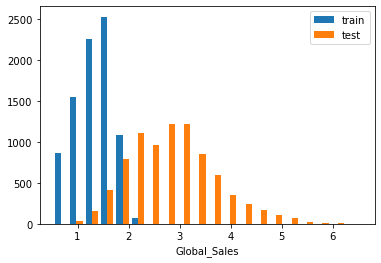

In [18]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.hist([np.log1p(y), np.log1p(df_pred['Global_Sales'])], bins=20, label=['train', 'test'])
ax.legend()
ax.set_xlabel('Global_Sales')

In [19]:
FILENAME = 'submission_cat.csv'
OUTPUT_DIR = '../outputs/'
filepath = os.path.join(OUTPUT_DIR, FILENAME)
df_pred.to_csv(filepath, index=False)
print(filepath)

../outputs/submission_cat.csv


In [20]:
print('- feat =', column_cnt)
print('- mean = {:.4f}'.format(pred_mean))
print('- max = {:.4f}'.format(pred_max))
print('- cat = {:.4f}'.format(score))

- feat = 1431
- mean = 25.0991
- max = 696.4872
- cat = 0.8369


#### 28cat: groupKfold -> StratifiedKFold
- feat = 1431
- mean = 25.0991
- max = 696.4872
- cat = 0.8369
- LB = 0.9006

#### 27cat
- feat = 1431
- mean = 23.7676
- max = 432.5676
- cat = 1.0556

#### 26cat
- feat = 1442
- mean = 21.8695
- max = 382.0561
- cat = 1.0572

#### 25cat
- feat = 1432
- mean = 24.9464
- max = 505.2158
- cat = 1.0565

#### 23cat
- feat = 1452
- mean = 16.5429
- max = 335.4926
- cat = 1.0367

#### 22cat: catboost
- feat = 1432
- mean = 24.2944
- max = 516.1847
- cat = 1.0980

#### 21cat: catboost (learning_rate=0.01)
- feat = 1421
- mean = 24.3766
- max = 526.5783
- score = 1.0733
- LB= 0.9055

#### 20cat: catboost
- feat = 1421
- mean = 24.6113
- max = 362.5455
- score = 1.1017
- LB= 0.929

#### 20lgbm
- feat = 1421
- mean = 24.6853
- max = 532.8670
- score = 1.0875

#### 11: target_encでUser_Score/Critic_Score
- feat = 1420
- mean = 23.8047
- max = 489.9664
- score = 1.0795
- LB= 0.9001　★best★